In [46]:
name = "Gustavo David Quintero Alvarez"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)


Name:  Gustavo David Quintero Alvarez

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



# MAC0460 / MAC5832 (2022)
<hr>

# EP2: Linear regression - analytic solution

### Objectives:

- to implement and test the analytic solution for the linear regression task (see, for instance, <a href="http://work.caltech.edu/slides/slides03.pdf">Slides of Lecture 03</a> of *Learning from Data*)
- to understand the core idea (*optimization of a loss or cost function*) for parameter adjustment in machine learning

### What to do:
- some cells of this notebook must be filled. Places to be filled are indicated as:
<code>
    \# START OF YOUR CODE:
    
    \# END OF YOUR CODE
</code> 
<hr>

# Linear regression

Given a dataset $\{(\mathbf{x}^{(1)}, y^{(1)}), \dots ,(\mathbf{x}^{(N)}, y^{(N)})\}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$ and $y^{(i)} \in \mathbb{R}$, we would like to approximate the unknown function $f:\mathbb{R}^{d} \rightarrow \mathbb{R}$ (recall that $y^{(i)} =f(\mathbf{x}^{(i)})$) by means of a linear model $h$:
$$
h(\mathbf{x}^{(i)}; \mathbf{w}, b) = \mathbf{w}^\top  \mathbf{x}^{(i)} + b
$$

Note that $h(\mathbf{x}^{(i)}; \mathbf{w}, b)$ is, in fact, an  [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) of  $\mathbf{x}^{(i)}$. As commonly done, we will use the term "linear" to refer to an affine transformation.

The output of $h$ is a linear transformation of $\mathbf{x}^{(i)}$. We use the notation $h(\mathbf{x}^{(i)}; \mathbf{w}, b)$ to make clear that $h$ is a parametric model, i.e., the transformation $h$ is defined  by the parameters $\mathbf{w}$ and $b$. We can view vector $\mathbf{w}$ as a *weight* vector that controls the effect of each *feature* in the prediction.

By adding one component with value equal to 1 to the observations $\mathbf{x}$ (an artificial coordinate), we have:

$$\tilde{\mathbf{x}} = (1, x_1, \ldots, x_d) \in \mathbb{R}^{1+d}$$

and then we can simplify the notation:
$$
h(\mathbf{x}^{(i)}; \mathbf{w}) = \hat{y}^{(i)} = \mathbf{w}^\top  \tilde{\mathbf{x}}^{(i)}
$$

We would like to determine the optimal parameters $\mathbf{w}$ such that prediction $\hat{y}^{(i)}$ is as closest as possible to $y^{(i)}$ according to some error metric. Adopting the *mean square error* as such metric we have the following cost function:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

Thus, the task of determining a function $h$ that is closest to $f$ is reduced to the task of finding the values $\mathbf{w}$ that minimize $J(\mathbf{w})$.



## Some imports

In [47]:
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline

### Auxiliary functions
The two auxiliary functions below are for generating simulated data and for plotting data.

In [48]:
# An auxiliary function
def get_housing_prices_data(N, verbose=True):
    """
    Generates artificial linear data,
    where x = square meter, y = house price

    :param N: data set size
    :type N: int
    
    :param verbose: param to control print
    :type verbose: bool
    :return: design matrix, regression targets
    :rtype: np.array, np.array
    """
    cond = False
    while not cond:
        x = np.linspace(90, 1200, N)
        gamma = np.random.normal(30, 10, x.size)
        y = 50 * x + gamma * 400
        x = x.astype("float32")
        x = x.reshape((x.shape[0], 1))
        y = y.astype("float32")
        y = y.reshape((y.shape[0], 1))
        cond = min(y) > 0
        
    xmean, xsdt, xmax, xmin = np.mean(x), np.std(x), np.max(x), np.min(x)
    ymean, ysdt, ymax, ymin = np.mean(y), np.std(y), np.max(y), np.min(y)
    if verbose:
        print("\nX shape = {}".format(x.shape))
        print("y shape = {}\n".format(y.shape))
        print("X: mean {}, sdt {:.2f}, max {:.2f}, min {:.2f}".format(xmean,
                                                               xsdt,
                                                               xmax,
                                                               xmin))
        print("y: mean {:.2f}, sdt {:.2f}, max {:.2f}, min {:.2f}".format(ymean,
                                                                 ysdt,
                                                                 ymax,
                                                                 ymin))
    return x, y

In [49]:
# Another auxiliary function
def plot_points_regression(x,
                           y,
                           title,
                           xlabel,
                           ylabel,
                           prediction=None,
                           legend=False,
                           r_squared=None,
                           position=(90, 100)):
    """
    Plots the data points and the prediction,
    if there is one.

    :param x: design matrix
    :type x: np.array
    :param y: regression targets
    :type y: np.array
    :param title: plot's title
    :type title: str
    :param xlabel: x axis label
    :type xlabel: str
    :param ylabel: y axis label
    :type ylabel: str
    :param prediction: model's prediction
    :type prediction: np.array
    :param legend: param to control print legends
    :type legend: bool
    :param r_squared: r^2 value
    :type r_squared: float
    :param position: text position
    :type position: tuple
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    line1, = ax.plot(x, y, 'bo', label='Real data')
    if prediction is not None:
        line2, = ax.plot(x, prediction, 'r', label='Predicted data')
        if legend:
            plt.legend(handles=[line1, line2], loc=2)
        ax.set_title(title,
                 fontsize=20,
                 fontweight='bold')
    if r_squared is not None:
        bbox_props = dict(boxstyle="square,pad=0.3",
                          fc="white", ec="black", lw=0.2)
        t = ax.text(position[0], position[1], "$R^2 ={:.4f}$".format(r_squared),
                    size=15, bbox=bbox_props)

    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    plt.show()


### The dataset and the task

The first dataset we will use is a toy dataset. We will generate $N=100$ observations with only one *feature* and a real value associated to each of them. We can view these observations as being pairs *(area of a real state in square meters, price of the real state)*. Our task is to construct a model that is able to predict the price of a real state, given its area.

### Ploting the data

In [50]:
X, y = get_housing_prices_data(N=100)


X shape = (100, 1)
y shape = (100, 1)

X: mean 645.0, sdt 323.65, max 1200.00, min 90.00
y: mean 44655.98, sdt 16352.49, max 76041.69, min 12299.00


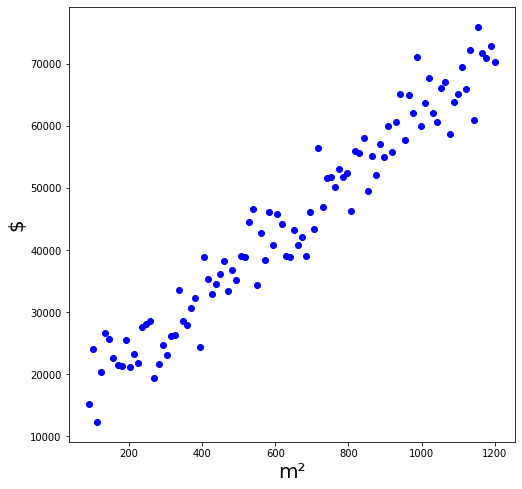

In [51]:
plot_points_regression(X,
                       y,
                       title='Real estate prices prediction',
                       xlabel="m\u00b2",
                       ylabel='$')

### The solution

Given $f:\mathbb{R}^{N\times M} \rightarrow \mathbb{R}$ and $\mathbf{A} \in \mathbb{R}^{N\times M}$, we define the gradient of $f$ with respect to $\mathbf{A}$ as:

\begin{equation*}
\nabla_{\mathbf{A}}f = \frac{\partial f}{\partial \mathbf{A}} =  \begin{bmatrix}
\frac{\partial f}{\partial \mathbf{A}_{1,1}} & \dots & \frac{\partial f}{\partial \mathbf{A}_{1,m}} \\
\vdots &  \ddots & \vdots \\
\frac{\partial f}{\partial \mathbf{A}_{n,1}} &  \dots & \frac{\partial f}{\partial \mathbf{A}_{n,m}}
\end{bmatrix}
\end{equation*}

Let $\mathbf{X} \in \mathbb{R}^{N\times (1+d)}$ be a matrix (sometimes also called the *design matrix*) whose rows are the extended observations of the dataset and let $\mathbf{y} \in \mathbb{R}^{N}$ be the vector consisting of all values $y^{(i)}$ (i.e., $\mathbf{X}^{(i,:)} = \mathbf{\tilde{x}}^{(i)}$ and $\mathbf{y}^{(i)} = y^{(i)}$). It can be verified that: 

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}(\mathbf{X}\mathbf{w} - \mathbf{y})^{T}(\mathbf{X}\mathbf{w} - \mathbf{y})
\end{equation}

Using basic matrix derivative concepts we can compute the gradient of $J(\mathbf{w})$ with respect to $\mathbf{w}$:

\begin{equation}
\nabla_{\mathbf{w}}J(\mathbf{w}) = \frac{2}{N} (\mathbf{X}^{T}\mathbf{X}\mathbf{w} -\mathbf{X}^{T}\mathbf{y})   
\end{equation}

Thus, when $\nabla_{\mathbf{w}}J(\mathbf{w}) = 0$ we have 

\begin{equation}
\mathbf{X}^{T}\mathbf{X}\mathbf{w} = \mathbf{X}^{T}\mathbf{y}
\end{equation}

Hence,

\begin{equation}
\mathbf{w} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}
\end{equation}

Note that this solution has a high computational cost. As the number of variables (*features*) increases, the cost for matrix inversion becomes prohibitive. See  [this text](https://sgfin.github.io/files/notes/CS229_Lecture_Notes.pdf) for more details.

## NumPy
Quoted from [NumPy documentation](https://numpy.org/doc/stable/): "NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more."

A quick introduction to this library can be found [here](http://cs231n.github.io/python-numpy-tutorial/). Particularly useful for this EP (and this course) are the "array math" related tools.

# <mark>Exercise 1</mark>
The objective of this exercise is to apply the solution just described on the dataset above created.

Using only **NumPy**, complete the two functions below. Recall that $\mathbf{X} \in \mathbb{R}^{N\times d}$; thus you will need to add a component of value 1 to each of  the observations in $\mathbf{X}$ before performing the computation described above.

NOTE: Although the dataset above has data of dimension $d=1$, your code must be generic (it should work for $d\geq1$)

## <mark>1.1. Weight computation function</mark>

In [52]:
def normal_equation_weights(X, y):
    """
    Calculates the weights of a linear function using the normal equation method.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d, 1))
    """
    
    # START OF YOUR CODE:
    
    # Defining the dimension of the dataset:
    N = X.shape[0]
    
    # Adding a vector of ones in the first column of X:
    X = np.hstack((np.ones((N,1)),X))
    
    # Defining the matrix A as the product of X^t and X:
    A = np.matmul(np.transpose(X),X)
    
    # Defining the vector as the product of X^t and y:
    b = np.matmul(np.transpose(X),y)
          
    # Returning the solution w = (A^-1)*b:
    return np.matmul(np.linalg.inv(A),b)

    # END OF YOUR CODE
    

In [53]:
# test of function normal_equation_weights()

w = 0  # this is not necessary
w = normal_equation_weights(X, y)
print("Estimated w =\n", w)

Estimated w =
 [[12942.80257962]
 [   49.16771871]]


## <mark>1.2. Prediction function</mark>

In [54]:
def normal_equation_prediction(X, w):
    """
    Calculates the prediction over a set of observations X using the linear function
    characterized by the weight vector w.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param w: weight vector
    :type w: np.ndarray(shape=(1+d, 1))
    :param y: regression prediction
    :type y: np.ndarray(shape=(N, 1))
    """
    
    # START OF YOUR CODE:
    
    # Defining the dimension of the dataset:
    N = X.shape[0]
    
    # Adding a vector of ones in the first column of X:
    X = np.hstack((np.ones((N,1)),X))
    
    # Computing and returning the prediction:
    return np.matmul(X,w)

    # END OF YOUR CODE


## <mark>1.3. Coefficient of determination</mark>
We can use the [$R^2$](https://pt.wikipedia.org/wiki/R%C2%B2) metric (Coefficient of determination) to evaluate how well the linear model fits the data.

**Which $𝑅^2$ value would you expect to observe ?**

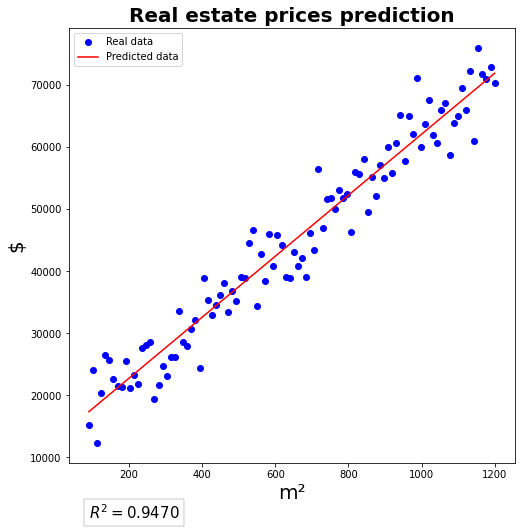

In [55]:
from sklearn.metrics import r2_score

# test of function normal_equation_prediction()
prediction = normal_equation_prediction(X, w)

# compute the R2 score using the r2_score function from sklearn
# Replace 0 with an appropriate call of the function

# START OF YOUR CODE:
r_2 = r2_score(y,prediction)
# END OF YOUR CODE

plot_points_regression(X,
                       y,
                       title='Real estate prices prediction',
                       xlabel="m\u00b2",
                       ylabel='$',
                       prediction=prediction,
                       legend=True,
                       r_squared=r_2)

## Additional tests

Let us compute a prediction for $x=650$


In [56]:
# Let us use the prediction function
x = np.asarray([650]).reshape(1,1)
prediction = normal_equation_prediction(x, w)
print("Area = %.2f  Predicted price = %.4f" %(x[0], prediction))

Area = 650.00  Predicted price = 44901.8197


## <mark>1.4. Processing time</mark>

Experiment with different number of samples $N$ and observe how processing time varies.

Be careful not to use a too large value; it may make jupyter freeze ...

In [57]:
# Add other values for N
# START OF YOUR CODE:
N = [500,1000,2000,4000,8000,16000,32000] 
# END OF YOUR CODE

for i in N:
    X, y = get_housing_prices_data(N=i)
    init = time.time()
    w = normal_equation_weights(X, y)
    prediction = normal_equation_prediction(X,w)
    init = time.time() - init
    
    print("\nExecution time = {:.8f}(s)\n".format(init))


X shape = (500, 1)
y shape = (500, 1)

X: mean 645.0, sdt 321.07, max 1200.00, min 90.00
y: mean 44020.36, sdt 16803.54, max 79896.70, min 9671.54

Execution time = 0.00000000(s)


X shape = (1000, 1)
y shape = (1000, 1)

X: mean 645.0, sdt 320.75, max 1200.00, min 90.00
y: mean 44125.08, sdt 16272.72, max 79175.85, min 8445.11

Execution time = 0.00000000(s)


X shape = (2000, 1)
y shape = (2000, 1)

X: mean 645.0, sdt 320.59, max 1200.00, min 90.00
y: mean 44220.10, sdt 16403.30, max 81810.73, min 8265.14

Execution time = 0.00109363(s)


X shape = (4000, 1)
y shape = (4000, 1)

X: mean 645.0, sdt 320.51, max 1200.00, min 90.00
y: mean 44298.07, sdt 16505.07, max 80953.39, min 4984.78

Execution time = 0.00000000(s)


X shape = (8000, 1)
y shape = (8000, 1)

X: mean 645.0, sdt 320.47, max 1200.00, min 90.00
y: mean 44230.16, sdt 16484.22, max 81347.59, min 5928.12

Execution time = 0.00100279(s)


X shape = (16000, 1)
y shape = (16000, 1)

X: mean 645.0, sdt 320.45, max 1200.00, min

# <mark>Exercise 2</mark>

In this exercise, the goal is to play with the data we have collected in our first class. Download the data file from [here](https://edisciplinas.usp.br/draftfile.php/5062945/user/draft/622707057/dataMAC0460_5832.csv) (or directly from e-disciplinas, seção Tarefas). 
We will also try to explore cases where $d>1$.

Note that there might be some invalid data entries. It is up to you how you will handle those data. Note that if you decide to do some pre-processing of the dataset, it should be done in this notebook (you are not allowed to edit the CSV datasheet). Feel free to added new cells if that helps to better organize your code.


## Reading the dataset

In [58]:
import pandas as pd

# load the dataset
df = pd.read_csv('dataMAC0460_5832.csv')
df.head()

,Sex,Age,Height,Weight,Shoe number,Trouser number
0,Female,53,154,59,36,40
1,Male,23,170,56,40,38
2,Female,23,167,63,37,40
3,Male,21,178,78,40,40
4,Female,25,153,58,36,38


In [59]:
df.describe()

,Age,Height,Weight,Shoe number
count,202.000000,202.000000,202.000000,202.000000
mean,28.133663,171.084158,72.004950,39.777228
std,11.934604,12.808496,17.093392,2.857281
min,3.000000,65.000000,15.000000,24.000000
25%,21.000000,166.250000,61.000000,38.000000
50%,23.000000,172.500000,70.000000,40.000000
75%,29.750000,178.000000,81.750000,42.000000
max,67.000000,194.000000,159.000000,46.000000


### Let's establish 'Weight' as the target variable

In [60]:
# Our target variable is the Weight
y = df['Weight']
y

0      59
1      56
2      63
3      78
4      58
       ..
197    57
198    68
199    65
200    51
201    62
Name: Weight, Length: 202, dtype: int64

## <mark>2.1. One feature ($d=1$)</mark>

We will use 'Height' as the input feature and predict the weight

In [61]:
feature_cols = ['Height']
X = df.loc[:, feature_cols]
X.shape

(202, 1)

Write the code for computing the following
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute the $R^2$ value
- plot the regression graph (use appropriate values for the parameters of function <tt>plot_points_regression()</tt>)

InvalidIndexError: (slice(None, None, None), None)

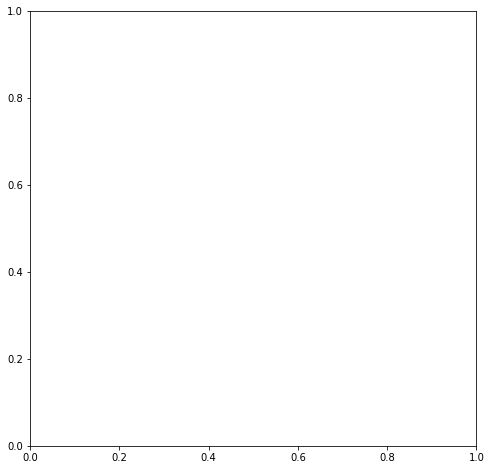

In [68]:
# START OF YOUR CODE:

# Computing the regression weights using X and y:
w = normal_equation_weights(X, y)

# Computing prediction:
prediction = normal_equation_prediction(X, w)

# Computing the R^2 value:
r_2 = r2_score(y,prediction)

# Ploting the regression graph:
plot_points_regression(X,
                       y,
                       title='Weight prediction from height',
                       xlabel="Weight",
                       ylabel="Height",
                       prediction=prediction,
                       legend=True,
                       r_squared=r_2)
# END OF YOUR CODE


## <mark>2.2 - Two input features ($d=2$)</mark>

Now repeat the exercise using as input the features 'Height' and 'Shoe number'

- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

Note that our plotting function can not be used for this dataset. Here tehre is no need to do the plotting.

In [ ]:
# START OF YOUR CODE:

# END OF YOUR CODE


## 2.3 - <mark>Three input features ($d=3$)</mark>

Now try with three features. There is no need to do plotting here.
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

In [ ]:
# START OF YOUR CODE:

# END OF YOUR CODE


# 3. <mark>Your comments</mark>

Write any comments about your implementation or about the results you observed.

===>


